In [2]:
import os
import json
import zipfile
import requests
from urllib.request import urlretrieve

import pandas as pd
import re
import glob
import time


## Download Data

In [3]:
article_id = 14096681  # this is the unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}/versions/3"
headers = {"Content-Type": "application/json"}


response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)["files"]

download_url = [item["download_url"] for item in data if item["name"] == "data.zip"][0]
download_url

output_directory = "data/"
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
urlretrieve(download_url, output_directory + "rainfall.zip")

with zipfile.ZipFile(os.path.join(output_directory, "rainfall.zip"), 'r') as f:
    f.extractall(output_directory)
# output_directory = "figshareairline/"

## Combine CSV

### Combine all the CSVs using Python

In [6]:
%%time
files = glob.glob("data/*.csv")
files.remove("data/observed_daily_rainfall_SYD.csv")
df = pd.concat(
    (pd.read_csv(file, index_col=0, parse_dates=['time'])
     .assign(model=re.findall(r'[^\/&\\]+(?=_daily_rainfall_NSW\.)', file)[0])
        )
     for file in files
)
df.to_csv("data/combined_data.csv")


CPU times: user 8min 4s, sys: 25.5 s, total: 8min 30s
Wall time: 8min 46s


In [8]:
df.head(5)

,lat_min,lat_max,lon_min,lon_max,rain (mm/day),model
time,,,,,,
1889-01-01 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.244226e-13,MPI-ESM-1-2-HAM
1889-01-02 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.217326e-13,MPI-ESM-1-2-HAM
1889-01-03 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.498125e-13,MPI-ESM-1-2-HAM
1889-01-04 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.251282e-13,MPI-ESM-1-2-HAM
1889-01-05 12:00:00,-35.439867,-33.574619,141.5625,143.4375,4.270161e-13,MPI-ESM-1-2-HAM


#### Combine CSVs Time taken in each machine



| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Khalid      |   macOS Big Sur  | 8GB |    Intel  |   Y    |    8min    |
| Andy        |                  |     |           |        |            |
| Valli       |                  |     |           |        |            |
| Tuan        |                  |     |           |        |            |

## Observations

In [11]:
%load_ext memory_profiler

CPU times: user 1min 6s, sys: 23.1 s, total: 1min 29s
Wall time: 1min 41s


<AxesSubplot:>

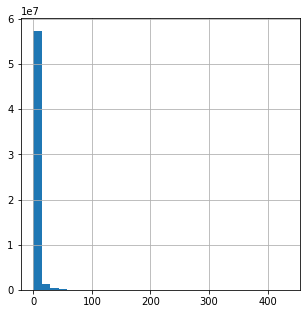

In [14]:
%%time
df = pd.read_csv("data/combined_data.csv", index_col=0)
df["rain (mm/day)"].hist(figsize=(5, 5), bins=30)

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Khalid      |   macOS Big Sur  | 8GB |    Intel  |   Y    |    1:41    |
| Andy        |                  |     |           |        |            |
| Valli       |                  |     |           |        |            |
| Tuan        |                  |     |           |        |            |

**Approach 1: Change the data type**

In [16]:
print(f"float64 memory usage: {df[['lat_min','lat_max','lon_min','lon_max','rain (mm/day)']].memory_usage().sum() / 1e6:.2f} MB")
print(f"float32 memory usage: {df[['lat_min','lat_max','lon_min','lon_max','rain (mm/day)']].astype('float32', errors='ignore').memory_usage().sum() / 1e6:.2f} MB")

float64 memory usage: 2998.46 MB
float32 memory usage: 1749.10 MB


peak memory: 3296.74 MiB, increment: 1167.91 MiB
CPU times: user 4.27 s, sys: 5.87 s, total: 10.1 s
Wall time: 15.8 s


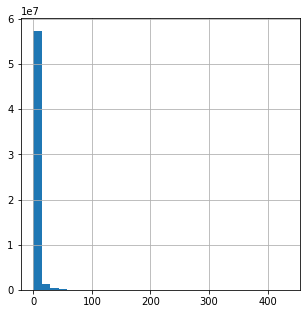

In [18]:
%%time
%%memit
df_dtype = df.astype({'lat_min': 'float32',
                      'lat_max': 'float32',
                      'lon_min': 'float32',
                      'lon_max': 'float32',
                      'rain (mm/day)': 'float32'})
df_dtype["rain (mm/day)"].hist(figsize=(5, 5), bins=30)

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Khalid      |   macOS Big Sur  | 8GB |    Intel  |   Y    |    15s     |
| Andy        |                  |     |           |        |            |
| Valli       |                  |     |           |        |            |
| Tuan        |                  |     |           |        |            |

**Observations**

- Changing the data type from float64 to float32 drastically improved the time taken from almost 2 minutes to mere 15 seconds
- Changing the data type also reduced the memory usage by half, which is a lot of saved memory!

**Loading all the necessary columns**


/opt/miniconda3/lib/python3.9/multiprocessing/resource_tracker.py:96: UserWarning: resource_tracker: process died unexpectedly, relaunching.  Some resources might leak.
  warnings.warn('resource_tracker: process died unexpectedly, '


peak memory: 3346.22 MiB, increment: 1464.20 MiB
CPU times: user 44.2 s, sys: 11.3 s, total: 55.5 s
Wall time: 1min 2s


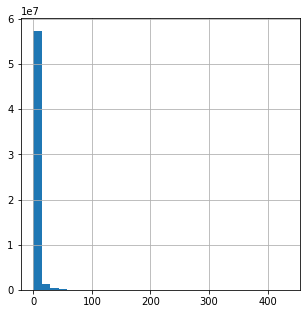

In [20]:
%%time
%%memit
useful_cols = ['time','rain (mm/day)']
df_columns = pd.read_csv("data/combined_data.csv",usecols=useful_cols)
df_columns["rain (mm/day)"].hist(figsize=(5, 5), bins=30)

| Team Member | Operating System | RAM | Processor | Is SSD | Time taken |
|:-----------:|:----------------:|:---:|:---------:|:------:|:----------:|
| Khalid      |   macOS Big Sur  | 8GB |    Intel  |   Y    |     1min   |
| Andy        |                  |     |           |        |            |
| Valli       |                  |     |           |        |            |
| Tuan        |                  |     |           |        |            |

**Observations**

Loading only the necessary columns reduced the processing time down to 1min (from 1min 40s). However, this is not as large of a improvement than changing the data type.